$V(x)=\sum_{t=0}^\infty \gamma^t R(x(t))$ \
where  $R(x)=Constant-\|x-x_{goal}\|-Variance>0$ \
and $\gamma=0.5$

# Create Environment

In [121]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

In [122]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [123]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    '''
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    '''
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-1*obs[3]-1*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r



# Learning Settings

In [124]:
global lr
lr=0.7
global eps
eps=0.1
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,std,init=False):
    explo=exploration()
    #print("cand",cand.shape)
    #print("std",std.shape)
    if init:
        return(np.random.randint(6)), True
    elif explo:
        return(find_max(std)), True
    else:
        return(find_max(cand)), False
    
def generate_history_pred(gp_list,history):
    cand=[]
    for j in range(len(gp_list)):
        pred=gp_list[j].predict(history.reshape(-1,5), return_std=False).reshape(-1,1)
        if j==0:
            cand=pred
        else:
            cand=np.concatenate((cand,pred),axis=1)
    output=[]
    for j in range(history.shape[0]):
        output.append([np.max(cand[j])])
    return np.array(output)
        
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)


def trainingset_refine(history_su,history_su_next, history_r, num=1000):
    if history_su.shape[0]<num:
        return history_su, history_su_next, history_r
    else:
        history_su=history_su[-num:-1]
        history_su_next=history_su_next[-num:-1]
        history_r=history_r[-num:-1]
        return history_su,history_su_next,history_r


history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [125]:
num_iter=200

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            std=[]
            u_k, _ = decide_u(observation,np.array(candidates_u),np.array(std),init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_su_next[u_k] = observation_new.reshape(-1,5)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            std=[]
            for i in range(6):
                cand, var = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
                std.append(var[0])
            #print(candidates_u)
            #print(var)
            u_k, explo = decide_u(observation,np.array(candidates_u),np.array(std))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            #if r>0.1:
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_target)
                
                '''
                for i in range(6):
                    hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
                    history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
                '''
     
            
            
    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-3).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:       
        for i in range(6):
            history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-3).fit(history_su[i], history_target)
            #print(history_su[i].shape[0])
        '''
        for i in range(6):
            hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
            history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
            print(history_su[i].shape[0])
        '''
            
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|▊                                                                                 | 2/200 [00:00<00:15, 12.53it/s]

observation = [-1.06506160e+00 -1.79006158e+00 -1.17809725e+00  4.43271322e-04
  2.66486260e-03]
observation = [-1.14407175e+00 -1.52634063e+00 -2.12057504e+00  4.02506353e-03
  2.45621219e-04]


  2%|█▋                                                                                | 4/200 [00:00<00:23,  8.24it/s]

observation = [-9.43952853e-01 -1.16907496e+00 -1.64933614e+00  6.53265286e-03
  1.19784972e-03]
observation = [-0.46882377 -0.62854193 -1.88495559  0.0139306   0.00265199]


  3%|██▍                                                                               | 6/200 [00:00<00:26,  7.42it/s]

observation = [-0.18140751 -0.31865521 -2.12057504  0.02172348  0.00421447]
observation = [-0.63227252 -0.95637336 -1.64933614  0.00563491  0.00345961]


  4%|███▎                                                                              | 8/200 [00:01<00:26,  7.35it/s]

observation = [-0.60150819 -0.64835591 -1.64933614  0.01258191  0.00360066]
observation = [-0.41836207  0.02801604 -1.88495559  0.02491952  0.005896  ]


  5%|████                                                                             | 10/200 [00:01<00:27,  6.97it/s]

observation = [-0.34451544  0.11066461 -1.64933614  0.02690515  0.0062814 ]
observation = [ 0.03371271  1.43911123 -3.06305284  0.06922242  0.01185266]


  6%|████▊                                                                            | 12/200 [00:01<00:26,  7.04it/s]

observation = [ 6.06821633e-01  9.12101160e-01 -2.35619449e+00  6.47131342e-02
  5.44743335e-04]
observation = [ 4.89860139e-01  2.53124284e+00 -8.71791961e+00  1.94287119e-02
  8.03474629e-03]


  7%|█████▋                                                                           | 14/200 [00:01<00:27,  6.82it/s]

observation = [ 0.02933529  1.81693192 -2.35619449  0.07503592  0.01105716]
observation = [ 7.44436300e-01  1.40368952e+00 -2.82743339e+00  8.25631792e-02
  8.01797986e-04]


  8%|██████▍                                                                          | 16/200 [00:02<00:26,  6.85it/s]

observation = [ 0.59127456  2.36816301 -2.12057504  0.11749331  0.0082595 ]
observation = [ 0.26612758  1.85313215 -1.88495559  0.08569827  0.00926482]


  9%|███████▎                                                                         | 18/200 [00:02<00:27,  6.72it/s]

observation = [ 4.56854421e-01  1.65956543e-02 -2.59181394e+00  3.86017067e-02
  3.73523974e-04]
observation = [ 4.64744160e-01  1.03667491e+00 -2.35619449e+00  6.51003362e-02
  1.85084563e-03]


 10%|████████                                                                         | 20/200 [00:02<00:26,  6.68it/s]

observation = [ 7.30397702e-01  8.48164481e-01 -2.59181394e+00  6.35356120e-02
  1.13710338e-04]
observation = [-0.01847852  0.47417282 -2.12057504  0.0435391   0.00338689]


 11%|████████▉                                                                        | 22/200 [00:03<00:27,  6.55it/s]

observation = [ 1.20049392e+00  1.25034665e+00 -2.59181394e+00  8.69686297e-02
  2.55252648e-03]
observation = [ 4.81256135e-01  1.71130709e-01 -2.59181394e+00  4.53302648e-02
  1.15421377e-03]


 12%|█████████▋                                                                       | 24/200 [00:03<00:27,  6.37it/s]

observation = [ 0.40794851  1.16620776 -2.59181394  0.06579114  0.00326981]
observation = [ 1.02766928e+00  1.26392098e+00 -2.59181394e+00  8.89492830e-02
  7.56055258e-04]


 13%|██████████▌                                                                      | 26/200 [00:03<00:27,  6.22it/s]

observation = [ 0.60699853  1.18065109 -2.82743339  0.07687786  0.00556933]
observation = [ 0.56568483  0.34311114 -2.59181394  0.04653173  0.00578367]


 14%|███████████▎                                                                     | 28/200 [00:04<00:28,  6.12it/s]

observation = [ 9.22283144e-01  1.33507835e+00 -2.12057504e+00  8.29639213e-02
  1.77128951e-03]
observation = [ 1.30133946e+00  8.98483254e-01 -2.59181394e+00  6.88334657e-02
  1.29733140e-04]


 15%|████████████▏                                                                    | 30/200 [00:04<00:28,  5.99it/s]

observation = [ 1.25692864e+00  1.32861846e+00 -2.12057504e+00  1.00865707e-01
  6.68231648e-04]
observation = [ 1.40100333e+00  1.10226460e+00 -2.12057504e+00  8.95132223e-02
  7.39532483e-04]


 16%|████████████▉                                                                    | 32/200 [00:04<00:28,  5.81it/s]

observation = [ 1.08032682e+00  6.00930388e-01 -2.59181394e+00  6.42168118e-02
  1.24361510e-03]
observation = [ 9.93240695e-01  1.35347101e+00 -2.35619449e+00  8.76331163e-02
  1.54276139e-03]


 17%|█████████████▊                                                                   | 34/200 [00:05<00:29,  5.66it/s]

observation = [ 1.18041003e+00  1.12361886e+00 -2.12057504e+00  8.14682632e-02
  9.55011523e-05]
observation = [ 1.48636668e+00  1.16510338e+00 -2.12057504e+00  9.08540904e-02
  6.62699139e-04]


 18%|██████████████▏                                                                  | 35/200 [00:05<00:29,  5.62it/s]

observation = [ 0.36462436  2.06299338 -2.12057504  0.07577077  0.01849731]
observation = [ 6.46041158e-01 -1.53355885e+00  2.35619449e-01  8.05881398e-03
  1.06606336e-03]


 19%|███████████████▍                                                                 | 38/200 [00:05<00:29,  5.40it/s]

observation = [ 1.49039085e+00  1.57115535e+00 -2.35619449e+00  9.62123883e-02
  5.84154603e-04]
observation = [ 1.11464351  1.65849455 -1.88495559  0.08423851  0.00313545]


 20%|████████████████▏                                                                | 40/200 [00:06<00:30,  5.32it/s]

observation = [ 1.63507743e+00  1.49357459e+00 -2.35619449e+00  9.95714287e-02
  1.98111145e-03]
observation = [ 1.63127269e+00  1.43370747e+00 -2.35619449e+00  9.44429274e-02
  1.40625367e-03]


 20%|████████████████▌                                                                | 41/200 [00:06<00:30,  5.21it/s]

observation = [ 1.57367764e+00  8.35939697e-01 -2.35619449e+00  7.45636456e-02
  5.07274736e-04]


 22%|█████████████████▍                                                               | 43/200 [00:06<00:31,  5.02it/s]

observation = [ 1.47608096e+00  1.18076423e+00 -2.35619449e+00  8.12770814e-02
  5.45749238e-04]
observation = [ 1.79076561e+00  1.31910515e+00 -2.59181394e+00  9.59949464e-02
  4.10182664e-04]


 22%|██████████████████▏                                                              | 45/200 [00:07<00:31,  4.88it/s]

observation = [ 1.80698760e+00  1.48356170e+00 -2.59181394e+00  1.00695921e-01
  9.72302986e-04]
observation = [ 1.40256082e+00  1.18357339e+00 -2.35619449e+00  7.42014286e-02
  8.23612760e-04]


 23%|██████████████████▋                                                              | 46/200 [00:07<00:31,  4.82it/s]

observation = [ 2.06796077e+00  7.19735163e-01 -2.35619449e+00  8.69352976e-02
  3.46371113e-04]


 24%|███████████████████                                                              | 47/200 [00:07<00:32,  4.73it/s]

observation = [ 1.76631548e+00  1.47013296e+00 -2.35619449e+00  9.65508848e-02
  9.75558950e-04]


 24%|███████████████████▍                                                             | 48/200 [00:07<00:33,  4.59it/s]

observation = [ 1.77736985e+00  1.34296894e+00 -2.35619449e+00  9.74839614e-02
  5.37420309e-04]


 24%|███████████████████▊                                                             | 49/200 [00:08<00:33,  4.51it/s]

observation = [ 1.50598292e+00  1.11262825e+00 -2.59181394e+00  7.37702663e-02
  2.05088196e-03]


 25%|████████████████████▎                                                            | 50/200 [00:08<00:34,  4.41it/s]

observation = [ 1.58242541e+00  1.45611943e+00 -2.59181394e+00  8.77394762e-02
  1.75915634e-03]


 26%|████████████████████▋                                                            | 51/200 [00:08<00:34,  4.34it/s]

observation = [ 1.28704563  1.9049107  -2.35619449  0.09469586  0.00392151]


 26%|█████████████████████                                                            | 52/200 [00:08<00:34,  4.27it/s]

observation = [ 1.54953777e+00  1.13725929e+00 -2.59181394e+00  7.92277652e-02
  2.16291208e-03]


 26%|█████████████████████▍                                                           | 53/200 [00:09<00:35,  4.19it/s]

observation = [ 1.75031196e+00  1.42567150e+00 -2.35619449e+00  9.59535392e-02
  8.08085470e-04]


 27%|█████████████████████▊                                                           | 54/200 [00:09<00:35,  4.12it/s]

observation = [ 1.88007387e+00  1.42750895e+00 -3.06305284e+00  8.30780541e-02
  1.22894437e-04]


 28%|██████████████████████▎                                                          | 55/200 [00:09<00:35,  4.06it/s]

observation = [ 0.99941556  2.03169433 -2.35619449  0.08622783  0.01540204]


 28%|██████████████████████▋                                                          | 56/200 [00:09<00:36,  3.99it/s]

observation = [ 1.85129557e+00  1.30787735e+00 -2.35619449e+00  8.63188884e-02
  9.58896117e-05]


 28%|███████████████████████                                                          | 57/200 [00:10<00:36,  3.93it/s]

observation = [ 1.78784438e+00  1.42932705e+00 -2.35619449e+00  8.97662368e-02
  4.77128380e-04]


 29%|███████████████████████▍                                                         | 58/200 [00:10<00:36,  3.85it/s]

observation = [ 1.80686429e+00  1.54249899e+00 -2.35619449e+00  9.08884608e-02
  9.02303449e-04]


 30%|███████████████████████▉                                                         | 59/200 [00:10<00:37,  3.78it/s]

observation = [ 0.8125638   2.36712348 -2.82743339  0.08479381  0.02587305]


 30%|████████████████████████▎                                                        | 60/200 [00:11<00:37,  3.73it/s]

observation = [ 0.68845021  2.37455612 -2.35619449  0.09192373  0.03873288]


 30%|████████████████████████▋                                                        | 61/200 [00:11<00:38,  3.63it/s]

observation = [ 2.00804827e+00  1.47212017e+00 -2.35619449e+00  9.20334244e-02
  1.19370981e-04]


 31%|█████████████████████████                                                        | 62/200 [00:11<00:38,  3.57it/s]

observation = [ 1.94293432e+00  1.36484305e+00 -2.59181394e+00  8.64431478e-02
  7.73665193e-05]


 32%|█████████████████████████▌                                                       | 63/200 [00:11<00:38,  3.52it/s]

observation = [ 2.11727618e+00  1.68562672e+00 -2.59181394e+00  1.06661899e-01
  5.17833241e-04]


 32%|█████████████████████████▉                                                       | 64/200 [00:12<00:39,  3.46it/s]

observation = [ 2.04821477e+00  2.20185158e+00 -2.12057504e+00  1.23258197e-01
  1.52548318e-03]


 32%|██████████████████████████▎                                                      | 65/200 [00:12<00:39,  3.38it/s]

observation = [ 2.32813074e+00  1.74506060e+00 -2.12057504e+00  1.04954188e-01
  1.07648264e-04]


 33%|██████████████████████████▋                                                      | 66/200 [00:12<00:40,  3.32it/s]

observation = [ 1.97209667e+00  1.38917077e+00 -2.35619449e+00  8.39505041e-02
  1.05729516e-03]


 34%|███████████████████████████▏                                                     | 67/200 [00:13<00:40,  3.26it/s]

observation = [ 1.99686284e+00  1.45736959e+00 -2.59181394e+00  9.10259769e-02
  1.75278858e-03]


 34%|███████████████████████████▌                                                     | 68/200 [00:13<00:41,  3.19it/s]

observation = [ 2.16982968e+00  1.87174671e+00 -2.35619449e+00  1.11335092e-01
  1.23202465e-03]


 34%|███████████████████████████▉                                                     | 69/200 [00:13<00:41,  3.16it/s]

observation = [ 2.17138911e+00  1.91307963e+00 -2.12057504e+00  1.14306100e-01
  1.47304731e-03]


 35%|████████████████████████████▎                                                    | 70/200 [00:14<00:42,  3.08it/s]

observation = [ 2.27902505e+00  1.99383215e+00 -2.35619449e+00  1.02636983e-01
  9.17364362e-04]


 36%|████████████████████████████▊                                                    | 71/200 [00:14<00:42,  3.04it/s]

observation = [ 2.52049391e+00  2.11022322e+00 -2.59181394e+00  1.40373353e-01
  1.35048722e-03]


 36%|█████████████████████████████▏                                                   | 72/200 [00:14<00:43,  2.98it/s]

observation = [ 2.29542071  1.90724498 -2.59181394  0.10984315  0.00404789]


 36%|█████████████████████████████▌                                                   | 73/200 [00:15<00:43,  2.91it/s]

observation = [ 2.28621387e+00  1.90793543e+00 -2.35619449e+00  1.02438537e-01
  7.97483802e-04]


 37%|█████████████████████████████▉                                                   | 74/200 [00:15<00:44,  2.84it/s]

observation = [ 2.29733178e+00  2.02320937e+00 -2.59181394e+00  1.16782808e-01
  1.89357431e-03]


 38%|██████████████████████████████▍                                                  | 75/200 [00:15<00:44,  2.79it/s]

observation = [ 2.10022011  2.11886463 -2.59181394  0.09741529  0.00292458]


 38%|██████████████████████████████▊                                                  | 76/200 [00:16<00:45,  2.74it/s]

observation = [ 2.30185584e+00  1.99248273e+00 -2.35619449e+00  1.07197926e-01
  9.53953792e-04]


 38%|███████████████████████████████▏                                                 | 77/200 [00:16<00:45,  2.70it/s]

observation = [ 1.92291775  2.10044021 -2.82743339  0.08370283  0.00752375]


 39%|███████████████████████████████▌                                                 | 78/200 [00:17<00:46,  2.65it/s]

observation = [ 2.19588171  1.94365819 -2.59181394  0.10257469  0.00451637]


 40%|███████████████████████████████▉                                                 | 79/200 [00:17<00:46,  2.60it/s]

observation = [ 2.41283420e+00  2.06856100e+00 -2.59181394e+00  1.01483900e-01
  6.32241223e-04]


 40%|████████████████████████████████▍                                                | 80/200 [00:17<00:47,  2.55it/s]

observation = [ 2.29339575  2.05843127 -2.35619449  0.09721202  0.00419613]


 40%|████████████████████████████████▊                                                | 81/200 [00:18<00:47,  2.51it/s]

observation = [ 2.38760853e+00  2.28719552e+00 -2.59181394e+00  1.06826757e-01
  2.10002166e-03]


 41%|█████████████████████████████████▏                                               | 82/200 [00:18<00:47,  2.46it/s]

observation = [ 2.37532234  2.00520447 -2.35619449  0.09916615  0.00311353]


 42%|█████████████████████████████████▌                                               | 83/200 [00:19<00:48,  2.42it/s]

observation = [ 2.47644842  2.09061649 -2.59181394  0.10577488  0.00306957]


 42%|██████████████████████████████████                                               | 84/200 [00:19<00:48,  2.38it/s]

observation = [ 2.30982973e+00  1.88347654e+00 -2.12057504e+00  8.97612156e-02
  2.02535886e-03]


 42%|██████████████████████████████████▍                                              | 85/200 [00:20<00:49,  2.33it/s]

observation = [ 2.61257419  2.18358105 -2.35619449  0.11546462  0.00330536]


 43%|██████████████████████████████████▊                                              | 86/200 [00:20<00:49,  2.29it/s]

observation = [ 2.01310694  1.96739123 -2.35619449  0.08190557  0.01180712]


 44%|███████████████████████████████████▏                                             | 87/200 [00:21<00:50,  2.25it/s]

observation = [ 1.20300329 -1.20211376  0.4712389   0.01130118  0.00315821]


 44%|███████████████████████████████████▋                                             | 88/200 [00:21<00:51,  2.17it/s]

observation = [ 1.2678176  -0.01805505 -1.17809725  0.01259051  0.01758469]


 44%|████████████████████████████████████                                             | 89/200 [00:21<00:51,  2.15it/s]

observation = [ 2.43783775e+00  1.97499646e+00 -2.12057504e+00  9.62409743e-02
  2.35792098e-03]


 45%|████████████████████████████████████▍                                            | 90/200 [00:22<00:52,  2.11it/s]

observation = [ 2.10660272  1.86607849 -2.12057504  0.07768444  0.01509341]


 46%|████████████████████████████████████▊                                            | 91/200 [00:22<00:52,  2.09it/s]

observation = [ 2.51851686  2.31388625 -2.82743339  0.10967475  0.01071593]


 46%|█████████████████████████████████████▎                                           | 92/200 [00:23<00:52,  2.04it/s]

observation = [ 1.69724862 -0.90849481  0.23561945  0.01359762  0.00569723]


 46%|█████████████████████████████████████▋                                           | 93/200 [00:23<00:53,  2.01it/s]

observation = [ 2.5863995   2.09005762 -2.35619449  0.1084677   0.00747047]


 47%|██████████████████████████████████████                                           | 94/200 [00:24<00:53,  1.97it/s]

observation = [ 1.60708166  2.42446699 -2.59181394  0.07415627  0.02842627]


 48%|██████████████████████████████████████▍                                          | 95/200 [00:25<00:54,  1.93it/s]

observation = [ 2.72624153  2.31041228 -2.35619449  0.11751953  0.00899041]


 48%|██████████████████████████████████████▉                                          | 96/200 [00:25<00:54,  1.90it/s]

observation = [ 2.62770585  1.91268261 -2.12057504  0.10065817  0.01002421]


 48%|███████████████████████████████████████▎                                         | 97/200 [00:26<00:55,  1.86it/s]

observation = [ 2.70263847  2.25940083 -2.59181394  0.11368393  0.00851732]


 49%|███████████████████████████████████████▋                                         | 98/200 [00:26<00:55,  1.83it/s]

observation = [ 2.72799989  2.27477908 -2.59181394  0.1152511   0.00836518]


 50%|████████████████████████████████████████                                         | 99/200 [00:27<00:56,  1.80it/s]

observation = [ 2.85886328e+00  2.19793242e+00 -2.12057504e+00  1.10809295e-01
  1.90707478e-03]


 50%|████████████████████████████████████████                                        | 100/200 [00:27<00:56,  1.76it/s]

observation = [ 2.91871411  2.1382949  -2.59181394  0.109205    0.00447008]


 50%|████████████████████████████████████████▍                                       | 101/200 [00:28<00:57,  1.73it/s]

observation = [ 2.84777339e+00  2.31952856e+00 -2.59181394e+00  1.13958426e-01
  2.57769039e-03]


 51%|████████████████████████████████████████▊                                       | 102/200 [00:29<00:58,  1.68it/s]

observation = [ 2.72244634  2.38788398 -2.59181394  0.09764097  0.00622159]


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:29<00:58,  1.66it/s]

observation = [ 2.66048588  2.32184637 -2.12057504  0.03613153  0.01371261]


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:30<00:59,  1.63it/s]

observation = [ 2.83378243  2.45605991 -2.82743339  0.08586027  0.0057484 ]


 52%|██████████████████████████████████████████                                      | 105/200 [00:31<00:59,  1.59it/s]

observation = [ 2.45015335  2.38615602 -2.82743339  0.08665242  0.01798172]


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:31<01:00,  1.56it/s]

observation = [ 1.96782748  2.2974556  -2.12057504  0.05865915  0.02633318]


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:32<01:01,  1.50it/s]

observation = [ 2.84233379  2.34520181 -2.35619449  0.0977775   0.00487564]


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:33<01:02,  1.48it/s]

observation = [ 2.52292842  2.30232509 -2.59181394  0.07909183  0.01316322]


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:33<01:02,  1.45it/s]

observation = [ 2.53913414  2.3295713  -2.35619449  0.0817514   0.02324069]


 55%|████████████████████████████████████████████                                    | 110/200 [00:34<01:03,  1.42it/s]

observation = [ 2.588693    2.23430948 -2.35619449  0.07045824  0.01332113]


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<01:03,  1.41it/s]

observation = [ 2.83532436  2.31124867 -2.59181394  0.09019094  0.01038971]


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:36<01:03,  1.39it/s]

observation = [ 2.87331658  2.26681763 -2.59181394  0.09788427  0.01718465]


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:36<01:03,  1.38it/s]

observation = [ 2.53313845  2.13168337 -2.35619449  0.07380844  0.00963586]


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:37<01:03,  1.36it/s]

observation = [ 2.68266721  1.92033515 -2.59181394  0.07009131  0.00482434]


 57%|██████████████████████████████████████████████                                  | 115/200 [00:38<01:03,  1.34it/s]

observation = [ 2.48635683  2.44416892 -2.82743339  0.07865427  0.01827226]


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:39<01:04,  1.31it/s]

observation = [ 2.80606226  2.51377505 -2.35619449  0.09210229  0.00685425]


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:39<01:04,  1.28it/s]

observation = [ 2.26377935  2.14956649 -2.59181394  0.06548625  0.01286075]


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:40<01:05,  1.25it/s]

observation = [ 2.48821159  2.17029598 -2.35619449  0.07774927  0.01997129]


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:41<01:06,  1.21it/s]

observation = [ 2.39884948  2.62478592 -2.82743339  0.08545056  0.02328568]


 60%|████████████████████████████████████████████████                                | 120/200 [00:42<01:07,  1.19it/s]

observation = [ 1.98103858  2.3896366  -2.82743339  0.06497431  0.02360923]


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:43<01:07,  1.17it/s]

observation = [ 2.73240837  2.45391142 -2.59181394  0.08853701  0.00659709]


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:44<01:08,  1.14it/s]

observation = [ 2.69987565  2.44110559 -2.82743339  0.09030422  0.01346294]


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:45<01:08,  1.12it/s]

observation = [ 2.73258919  1.92521267 -2.12057504  0.07563559  0.01073458]


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:46<01:09,  1.10it/s]

observation = [ 2.48542764  2.67250863 -2.82743339  0.08568691  0.01336304]


 62%|██████████████████████████████████████████████████                              | 125/200 [00:47<01:08,  1.09it/s]

observation = [ 2.75101801  2.18220318 -2.59181394  0.08077088  0.00824373]


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:48<01:09,  1.06it/s]

observation = [ 2.61065568  1.90686893 -1.88495559  0.06520681  0.00497169]


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:49<01:09,  1.05it/s]

observation = [ 2.50948401  1.86658633 -2.35619449  0.05475966  0.01035132]


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:50<01:10,  1.03it/s]

observation = [ 2.901868    1.9775136  -2.35619449  0.07996511  0.00949303]


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:51<01:10,  1.01it/s]

observation = [ 2.63422162  2.33278295 -2.82743339  0.08739605  0.02112846]


 65%|████████████████████████████████████████████████████                            | 130/200 [00:52<01:14,  1.06s/it]

observation = [ 2.67197814  1.79018741 -2.35619449  0.06873099  0.01704592]


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:53<01:13,  1.06s/it]

observation = [ 2.73138984  2.13002599 -2.35619449  0.07973565  0.0148283 ]


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:54<01:12,  1.07s/it]

observation = [ 2.72437141  2.1079377  -2.35619449  0.07863169  0.0145461 ]


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:55<01:12,  1.07s/it]

observation = [ 2.72352954  2.21405645 -2.35619449  0.08436629  0.01690727]


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:56<01:11,  1.09s/it]

observation = [ 2.7320373   2.24188703 -2.35619449  0.0850627   0.01774951]


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:57<01:11,  1.11s/it]

observation = [ 2.59769466  2.59665487 -2.82743339  0.08654588  0.01913538]


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:59<01:12,  1.13s/it]

observation = [ 2.70520539  2.20589423 -2.12057504  0.0792525   0.0161591 ]


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [01:00<01:12,  1.14s/it]

observation = [ 2.44804596  2.34820094 -2.59181394  0.07508578  0.02422697]


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [01:01<01:12,  1.16s/it]

observation = [ 2.84581466  2.34694054 -2.59181394  0.08886066  0.01314451]


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [01:02<01:11,  1.18s/it]

observation = [ 2.8255749   2.09368545 -2.59181394  0.07944442  0.01181534]


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:03<01:11,  1.20s/it]

observation = [ 2.7497774   2.35992159 -2.12057504  0.0729489   0.00900804]


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:05<01:11,  1.21s/it]

observation = [ 2.77239054  2.34885261 -2.35619449  0.080354    0.01002803]


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [01:06<01:11,  1.23s/it]

observation = [ 2.61996764  2.12539504 -2.59181394  0.10632574  0.01346643]


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [01:07<01:11,  1.26s/it]

observation = [ 2.64976228  2.59399154 -2.82743339  0.08017823  0.01489011]


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [01:09<01:11,  1.28s/it]

observation = [ 2.68482083  1.78204193 -2.59181394  0.06127997  0.00714521]


 72%|██████████████████████████████████████████████████████████                      | 145/200 [01:10<01:11,  1.30s/it]

observation = [ 2.7237665   2.44943148 -2.82743339  0.08381253  0.01253706]


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [01:11<01:11,  1.32s/it]

observation = [ 2.79130362  2.31852274 -2.82743339  0.07937582  0.00922134]


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [01:13<01:11,  1.34s/it]

observation = [ 2.87933523  2.04506399 -2.59181394  0.07514228  0.01019982]


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [01:14<01:10,  1.36s/it]

observation = [ 2.17195302  2.57396499 -2.35619449  0.07033233  0.03661387]


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [01:16<01:10,  1.38s/it]

observation = [ 2.93026725  2.41161997 -2.82743339  0.08856841  0.00861416]


 75%|████████████████████████████████████████████████████████████                    | 150/200 [01:17<01:10,  1.41s/it]

observation = [ 2.05560036  2.64866148 -2.35619449  0.06967021  0.03060456]


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [01:19<01:10,  1.44s/it]

observation = [ 2.90810189  1.89502713 -2.59181394  0.06738799  0.01424844]


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [01:20<01:10,  1.46s/it]

observation = [ 2.54356886  2.6650449  -2.82743339  0.07541112  0.02532973]


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [01:22<01:09,  1.49s/it]

observation = [ 2.82444193  1.86222047 -2.59181394  0.06394927  0.00729186]


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [01:23<01:09,  1.51s/it]

observation = [ 2.92618747e+00  2.23009033e+00 -2.59181394e+00  1.22497660e-01
  1.75966991e-03]


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [01:25<01:09,  1.54s/it]

observation = [ 2.86868075  1.97913029 -2.59181394  0.07350758  0.01730366]


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [01:26<01:08,  1.56s/it]

observation = [ 3.04732359  2.48757305 -2.35619449  0.08419569  0.01597294]


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [01:28<01:08,  1.59s/it]

observation = [ 2.42909116  0.17815313 -1.88495559  0.01995586  0.01602766]


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [01:30<01:08,  1.62s/it]

observation = [ 2.76608011  2.44725583 -2.82743339  0.07695273  0.01101582]


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [01:31<01:07,  1.64s/it]

observation = [ 2.48660555  2.53396486 -2.82743339  0.06441568  0.01723796]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [01:33<01:06,  1.66s/it]

observation = [ 2.95783982  2.23171544 -2.82743339  0.08228131  0.02096963]


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:35<01:05,  1.69s/it]

observation = [ 2.17448122  2.46642551 -2.12057504  0.06178779  0.03216632]


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [01:37<01:05,  1.72s/it]

observation = [ 2.70831267  2.64391768 -3.06305284  0.08600519  0.01539665]


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [01:39<01:08,  1.86s/it]

observation = [ 2.67541179  2.00035251 -2.59181394  0.06507708  0.01963914]


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [01:41<01:10,  1.96s/it]

observation = [ 2.63689404  2.48861903 -3.06305284  0.08449501  0.03335639]


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [01:43<01:09,  2.00s/it]

observation = [ 2.67395732  2.00582917 -2.59181394  0.06501473  0.019718  ]


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [01:45<01:08,  2.01s/it]

observation = [ 2.64101525  2.4825315  -3.06305284  0.0834612   0.03305507]


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [01:47<01:07,  2.04s/it]

observation = [ 3.1722542   2.39446044 -2.82743339  0.09503735  0.01252683]


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [01:49<01:04,  2.02s/it]

observation = [ 2.54601028  2.21527246 -3.06305284  0.06266456  0.02365052]


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [01:52<01:05,  2.10s/it]

observation = [ 2.72857408  2.52752786 -3.06305284  0.07605674  0.02114239]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:54<01:06,  2.20s/it]

observation = [ 2.46778615  2.42151689 -2.59181394  0.07075338  0.03301921]


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:56<01:04,  2.22s/it]

observation = [ 2.67180736  2.01305878 -2.59181394  0.06529787  0.01993191]


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:59<01:03,  2.28s/it]

observation = [ 2.1641402   2.30300992 -3.06305284  0.06481048  0.03930343]


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [02:01<01:00,  2.25s/it]

observation = [ 3.19579749  2.13315014 -3.29867229  0.07151779  0.00633901]


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [02:03<00:56,  2.19s/it]

observation = [ 2.73418774  2.44498981 -3.06305284  0.06885641  0.01787814]


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [02:05<00:55,  2.23s/it]

observation = [ 2.67320106  2.00491491 -2.59181394  0.06458222  0.01961585]


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [02:08<00:54,  2.28s/it]

observation = [ 2.67966296  2.21010409 -2.59181394  0.06719909  0.0240125 ]


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [02:10<00:54,  2.36s/it]

observation = [ 2.32763714  2.54007746 -2.59181394  0.05826718  0.02755594]


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [02:13<00:54,  2.47s/it]

observation = [ 2.30224122 -0.74159299  0.23561945  0.01911345  0.00766335]


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [02:16<00:53,  2.54s/it]

observation = [ 2.91678958  2.09018795 -2.59181394  0.06755682  0.00890575]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [02:19<00:52,  2.64s/it]

observation = [ 3.10163087  2.43159911 -2.59181394  0.08957905  0.01350754]


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [02:21<00:50,  2.64s/it]

observation = [ 2.53032215  2.1066372  -2.12057504  0.06051296  0.02385188]


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [02:24<00:47,  2.61s/it]

observation = [ 2.76331103  1.85219304 -2.35619449  0.05783966  0.01375792]


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [02:26<00:43,  2.56s/it]

observation = [ 3.13536813  2.33158386 -2.35619449  0.08529745  0.01109144]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [02:29<00:41,  2.58s/it]

observation = [ 2.21348153  2.38845081 -2.82743339  0.05102174  0.03530539]


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [02:31<00:39,  2.60s/it]

observation = [ 2.54718061  2.35171228 -2.82743339  0.06341186  0.0278735 ]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [02:34<00:36,  2.63s/it]

observation = [ 2.72297977  2.13619857 -2.82743339  0.06714456  0.02036887]


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [02:37<00:35,  2.76s/it]

observation = [ 2.75739912  2.35406024 -2.59181394  0.06083883  0.01528163]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [02:40<00:33,  2.76s/it]

observation = [ 1.72301864  2.08514578 -2.12057504  0.03223382  0.05127036]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [02:43<00:31,  2.82s/it]

observation = [2.48155976 0.1470099  0.4712389  0.01352069 0.02046796]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [02:46<00:28,  2.80s/it]

observation = [ 1.99599021  0.77158188 -1.17809725  0.01132354  0.03394712]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [02:48<00:25,  2.79s/it]

observation = [2.44486171e+00 4.24982951e-01 4.16333634e-18 1.26428418e-02
 2.63555364e-02]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [02:51<00:22,  2.77s/it]

observation = [2.93680769 0.80683662 0.4712389  0.01496366 0.03545911]


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [02:54<00:19,  2.72s/it]

observation = [1.76386122e+00 6.50944765e-01 6.93889390e-18 6.85488460e-03
 3.14309042e-02]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [02:56<00:16,  2.70s/it]

observation = [2.96407906 0.68570764 0.9424778  0.01565063 0.03246056]


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [02:59<00:13,  2.68s/it]

observation = [2.95135534 0.6564411  0.4712389  0.01534209 0.03170385]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [03:02<00:10,  2.68s/it]

observation = [2.75964341 0.85904033 1.17809725 0.01104236 0.03489643]


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [03:04<00:08,  2.68s/it]

observation = [ 2.86167237  0.74545259 -0.4712389   0.0131169   0.0335411 ]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [03:07<00:05,  2.70s/it]

observation = [2.85983434 0.8400119  0.70685835 0.01312783 0.03565282]


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [03:10<00:02,  2.73s/it]

observation = [2.75391626 0.93315546 0.9424778  0.01086033 0.03702786]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:13<00:00,  1.03it/s]

observation = [2.7292538  0.99710362 0.70685835 0.0103179  0.03868593]


# Results

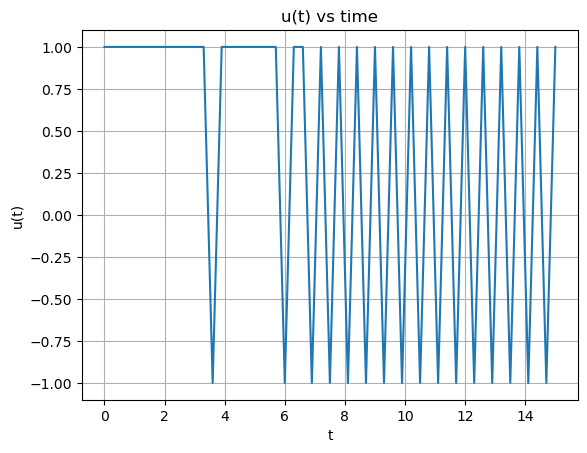

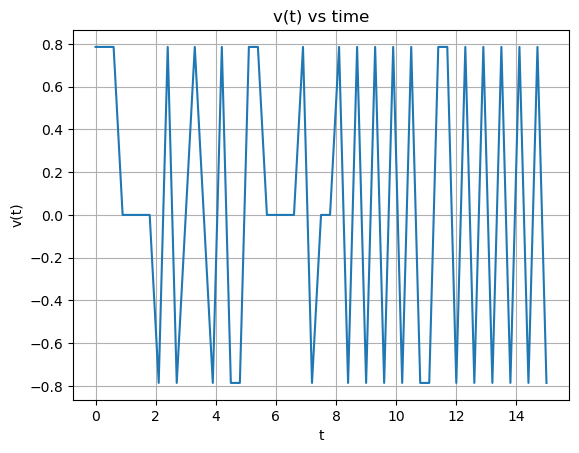

In [126]:
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


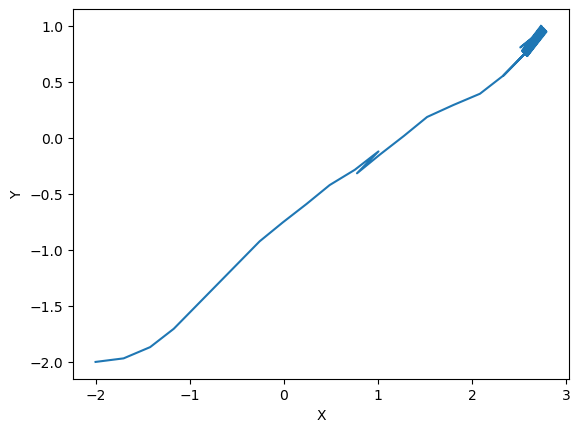

In [127]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

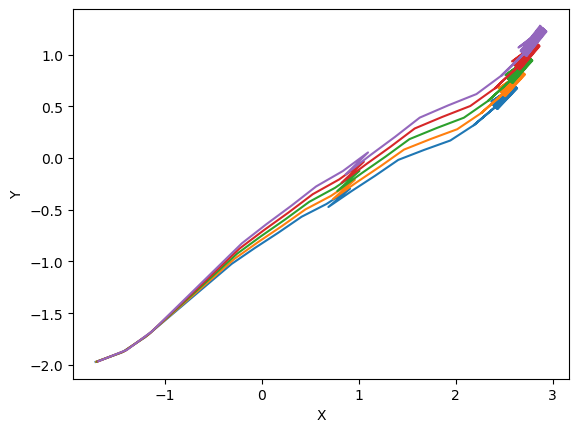

5.199573230003866


In [128]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Best Trajectory

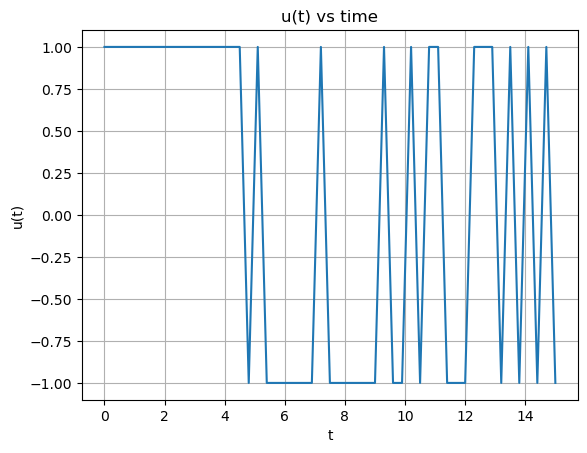

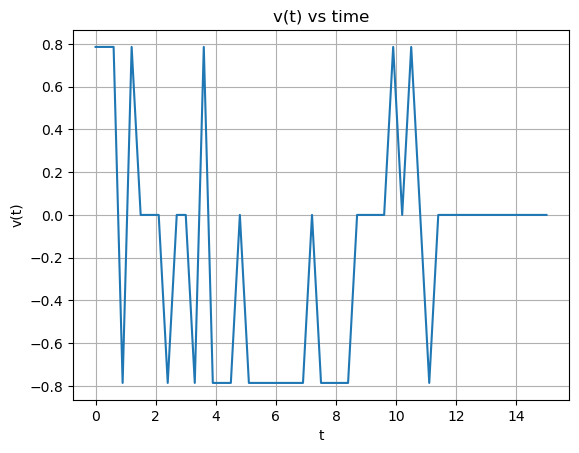

In [129]:
u=[2*(0.5-i%2) for i in best_u]
v=[(1-i//2)*np.pi/4 for i in best_u]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

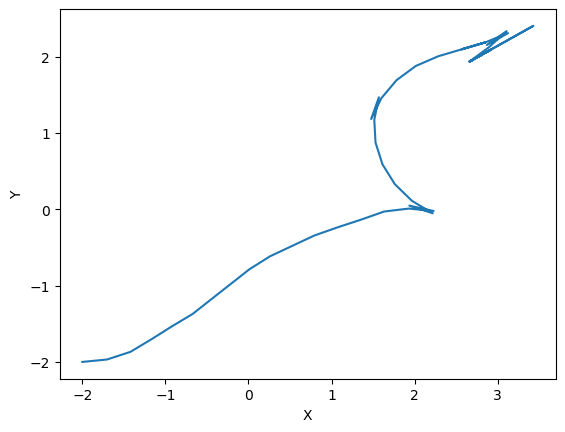

In [130]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

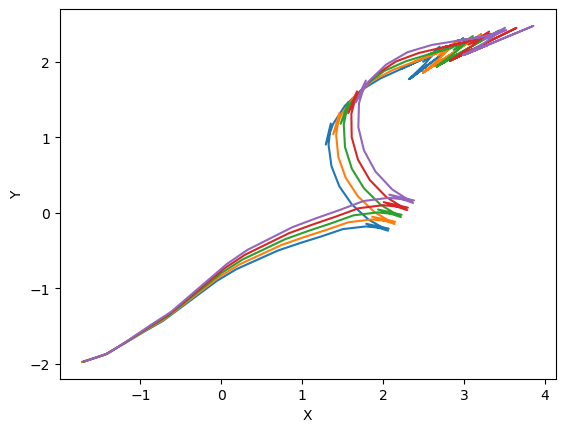

1.393912686719083


In [131]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

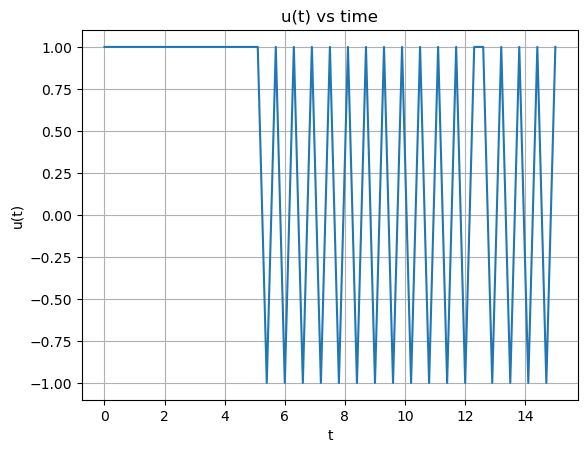

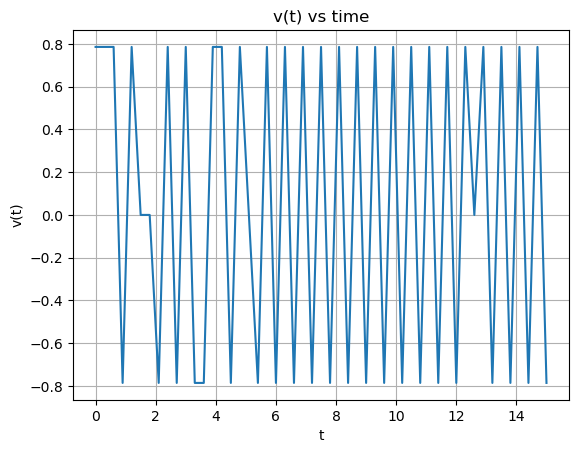

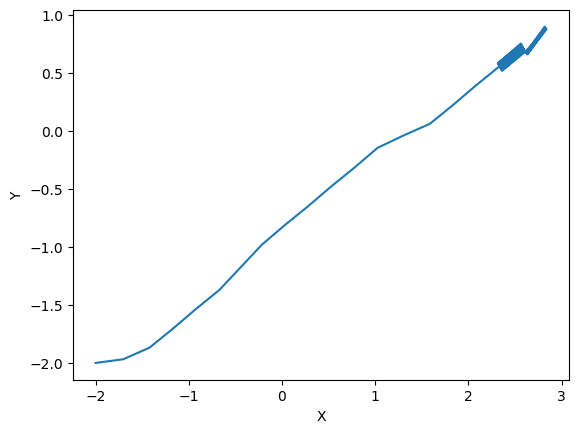

In [132]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''

    
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]


x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

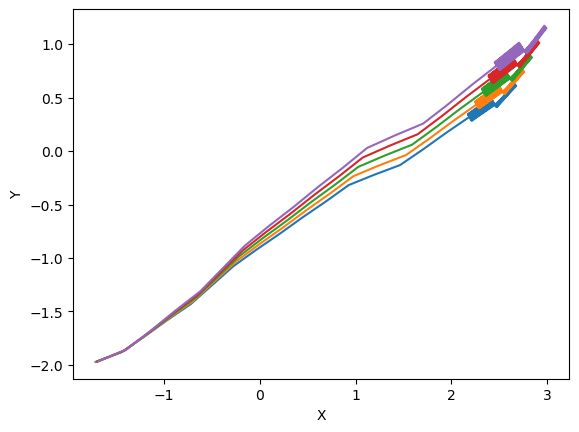

5.610392009872353


In [133]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

In [134]:
print(observation_t[-1])
#print(position_t[-1][0])

[2.81631833 0.89589295 0.70685835 0.01214478 0.03677145]


In [135]:
a=[1,2,4,8]
a[1:3]

[2, 4]